In [80]:
%load_ext autoreload
%autoreload 2

import scod
import torch
import numpy as np
from tqdm import trange

from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
class OneDDataset(torch.utils.data.Dataset):
    def __init__(self, N=100, fn=np.sin, split='train') -> None:
        super().__init__()
        if split == 'train':
            np.random.seed(1001)
        elif split == 'val':
            np.random.seed(2001)
        else:
            np.random.seed(3001)
        x = np.concatenate([-1.5 + np.random.rand(N//2), 0.5 + np.random.rand(N - N//2)])[:,None]
        y = fn(((x+3)/2)**2)
        noise_std = np.abs(0.05*x**2)
        noise = noise_std*np.random.randn(N,1)

        self.X = torch.from_numpy(x).float()
        self.Y = torch.from_numpy(y + noise).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx,:])


In [82]:
# DNN mapping 2d input to 1d distribution parameter 
model = torch.nn.Sequential(
    torch.nn.Linear(1, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1)
)

dist_layer = scod.distributions.NormalMeanParamLayer()
joint_model = torch.nn.Sequential(model, dist_layer)

mean_loss=-1.016189: 100%|██████████| 200/200 [00:01<00:00, 186.21it/s]


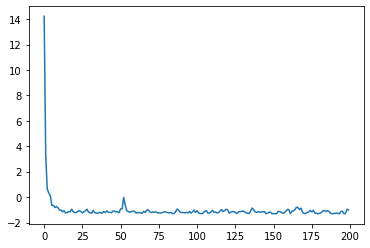

In [83]:
dataset = OneDDataset()
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
optimizer = torch.optim.Adam(joint_model.parameters(), lr=1e-2)

losses = []
t = trange(200)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()
        
        dist = joint_model(inputs)
        loss = -dist.log_prob(targets)

        mean_loss = loss.mean()

        mean_loss.backward()

        epoch_loss += mean_loss
        
        optimizer.step()
        
    epoch_loss /= len(train_dataloader)
    
    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

plt.plot(losses)

In [84]:
default_unc_model = scod.SCOD(model, args={
    'num_eigs': 100,
    'num_samples': 604,
    'sketch_type': 'srft',
    'prior_type': 'scalar'
})

fwd_kl_unc_model = scod.SCOD(model, args={
    'num_eigs': 100,
    'num_samples': 604,
    'sketch_type': 'srft',
    'prior_type': 'per_weight'
})

rev_kl_unc_model = scod.SCOD(model, args={
    'num_eigs': 100,
    'num_samples': 604,
    'sketch_type': 'srft',
    'prior_type': 'per_weight'
})

wass_unc_model = scod.SCOD(model, args={
    'num_eigs': 100,
    'num_samples': 604,
    'sketch_type': 'srft',
    'prior_type': 'per_weight'
})

Weight space dimension: 8.513e+03
Weight space dimension: 8.513e+03
Weight space dimension: 8.513e+03
Weight space dimension: 8.513e+03


In [102]:
def kernel(x):
    print(x.shape)
    length_scale = 0.1
    return torch.exp( - torch.norm(x[:,None,:] - x[None,:,:], dim=-1)**2 / length_scale**2 )

class UniformInputDataset(torch.utils.data.Dataset):
    def __init__(self, N=100, min=-3., max=3.):
        super().__init__()
        self.N = N
        self.range = max - min
        self.min = min

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.min + self.range*torch.rand(1), torch.zeros(1))

unif_dataset = UniformInputDataset(N=400)

losses,_ = scod.prior_optim.optimize_prior_scale_by_GP_kernel(
    fwd_kl_unc_model,
    unif_dataset,
    GP_kernel=kernel,
    dataloader_kwargs={'num_workers': 0, 'batch_size':50},
    num_epochs=40,
    dist_loss='fwd_kl'
)

plt.plot(losses)

losses,_ = scod.prior_optim.optimize_prior_scale_by_GP_kernel(
    rev_kl_unc_model,
    unif_dataset,
    GP_kernel=kernel,
    dataloader_kwargs={'num_workers': 0,'batch_size':50},
    num_epochs=20,
    dist_loss='rev_kl'
)

plt.plot(losses)

losses,_ = scod.prior_optim.optimize_prior_scale_by_GP_kernel(
    wass_unc_model,
    unif_dataset,
    GP_kernel=kernel,
    dataloader_kwargs={'num_workers': 0,'batch_size':50},
    num_epochs=20,
    dist_loss='wass'
)

plt.plot(losses)

  0%|          | 0/40 [00:00<?, ?it/s]

torch.Size([50, 1])
torch.Size([50, 50]) torch.Size([50, 1])


RuntimeError: linalg.slogdet: A must be batches of square matrices, but they are 1 by 50 matrices

In [93]:
default_unc_model.process_dataset(dataset, dist_layer, dataloader_kwargs={'num_workers':0})
fwd_kl_unc_model.process_dataset(dataset, dist_layer, dataloader_kwargs={'num_workers': 0})
rev_kl_unc_model.process_dataset(dataset, dist_layer, dataloader_kwargs={'num_workers': 0})
wass_unc_model.process_dataset(dataset, dist_layer, dataloader_kwargs={'num_workers': 0})

computing basis
using T = 604


  0%|          | 0/100 [00:00<?, ?it/s]/Users/apoorva/code/scod-module/venv/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|██████████| 100/100 [00:00<00:00, 344.43it/s]


computing basis
using T = 604


100%|██████████| 100/100 [00:00<00:00, 354.79it/s]


computing basis
using T = 604


100%|██████████| 100/100 [00:00<00:00, 357.46it/s]


computing basis
using T = 604


100%|██████████| 100/100 [00:00<00:00, 355.64it/s]


In [94]:
settings = [
    {   
        'name': 'Unit Prior',
        'model': default_unc_model,
        'dist_layer': relu_dist_layer,
    },
    {   
        'name': 'Fwd KL',
        'model': fwd_kl_unc_model,
        'dist_layer': relu_dist_layer,
    },
    {   
        'name': 'Rev KL',
        'model': rev_kl_unc_model,
        'dist_layer': relu_dist_layer,
    },
    {   
        'name': 'Wass',
        'model': wass_unc_model,
        'dist_layer': relu_dist_layer,
    },
]

In [95]:
X = np.linspace(-3.,3.,200)
xx_tensor = torch.from_numpy(X).view(-1,1).float()

In [96]:
results = []
for setting in settings:
    scod_model = setting['model']
    
    z_mean, z_var = scod_model(xx_tensor)
    marg_dist = setting['dist_layer'].marginalize_gaussian(z_mean, z_var)
    z_var = z_var[:,:1]


    _, z_prior_var = scod_model(xx_tensor, use_prior=True)
    marg_prior_dist = setting['dist_layer'].marginalize_gaussian(z_mean, z_prior_var)
    z_prior_var = z_prior_var[:,:1]

    z_mean_dataset, _ = scod_model(dataset.X)
    z_mean_dataset = z_mean_dataset[:,:1]
    sq_err = (dataset.Y - z_mean_dataset)**2

    result = {
        'name': setting['name'],
        'z_mean': z_mean.detach().cpu().numpy().reshape(X.shape),
        'z_vars': z_var.detach().cpu().numpy().reshape(X.shape),
        'total_var': marg_dist.variance.detach().cpu().numpy().reshape(X.shape),
        'prior_z_vars': z_prior_var.detach().cpu().numpy().reshape(X.shape),
        'total_prior_var': marg_prior_dist.variance.detach().cpu().numpy().reshape(X.shape),
        'sq_err' : sq_err.detach().cpu().numpy()
    }
    
    results.append(result)

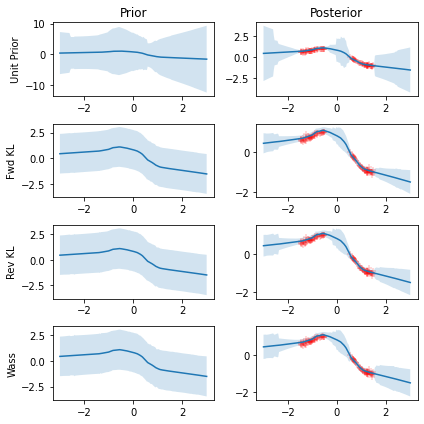

In [97]:
fig, axes = plt.subplots(len(results), 2, figsize=[6,6])

draw_y = True

for i, result in enumerate(results):
    yhat = result['z_mean']
    std = np.sqrt(result['total_prior_var'])
    axes[i,0].fill_between(X, draw_y*yhat + 1.92*std, draw_y*yhat - 1.92*std, alpha=0.2)
    axes[i,0].plot(X, draw_y*yhat)
    # axes[i,0].scatter(dataset.X[:,0], draw_y*dataset.Y)
    std = np.sqrt(result['total_var'])
    axes[i,1].fill_between(X, draw_y*yhat + 1.92*std, draw_y*yhat - 1.92*std, alpha=0.2)
    axes[i,1].plot(X, draw_y*yhat)
    axes[i,1].scatter(dataset.X[:,0], draw_y*dataset.Y, marker='+', alpha=0.2, color='red')
    
    axes[i,0].set_ylabel(result['name'])

axes[0,0].set_title('Prior')
axes[0,1].set_title('Posterior')

plt.tight_layout()
plt.savefig("prior_calib_1d.pdf")

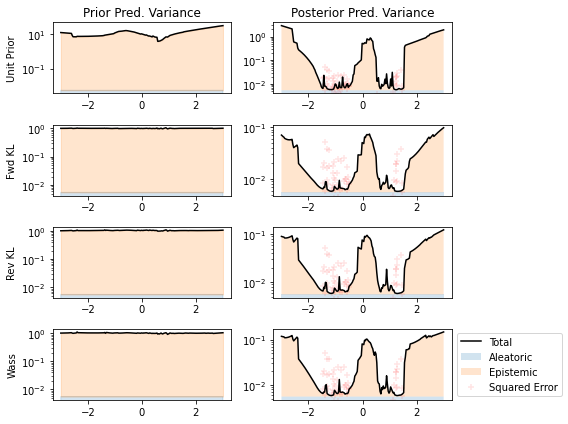

In [99]:
fig, axes = plt.subplots(len(results), 2, figsize=[8,6])

for i, result in enumerate(results):
    epistemic_prior = result['prior_z_vars']
    total_prior = result['total_prior_var'] 
    aleatoric_prior = total_prior - epistemic_prior
    axes[i,0].fill_between(X, aleatoric_prior, 0, alpha=0.2, color='C0', label="Aleatoric")
    # axes[i,0].plot(X, aleatoric_prior, color='C0')

    axes[i,0].fill_between(X, total_prior, aleatoric_prior, color='C1', alpha=0.2, label="Epistemic")
    axes[i,0].plot(X, total_prior, color='k', label="Total")    
    # axes[i,0].axhline(0, color='k')
    axes[i,0].set_yscale('log')


    epistemic = result['z_vars']
    total = result['total_var']
    aleatoric = total - epistemic
    axes[i,1].fill_between(X, aleatoric, 0, alpha=0.2, label="Aleatoric")
    # axes[i,1].plot(X, aleatoric, color='C0')
    axes[i,1].fill_between(X, total, aleatoric, alpha=0.2, label="Epistemic")
    axes[i,1].plot(X, total, color='k', label="Total")
    # axes[i,1].axhline(0, color='k')
    axes[i,1].set_yscale('log')

    # axes[i,1].axhline(np.mean(result['sq_err']), color='k', linestyle=':', label="Mean Squared Error")

    ylims = axes[i,1].get_ylim()
    axes[i,1].scatter(dataset.X[:,0], result['sq_err'], alpha=0.1, marker="+", color='red', label="Squared Error")
    axes[i,1].set_ylim(ylims)

    
    axes[i,0].set_ylabel(result['name'])

axes[0,0].set_title('Prior Pred. Variance')
axes[0,1].set_title('Posterior Pred. Variance')
axes[-1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.tight_layout()
plt.savefig("prior_scale_1d_var_only.pdf")